# Demographics figures & Gendar towards management figures

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

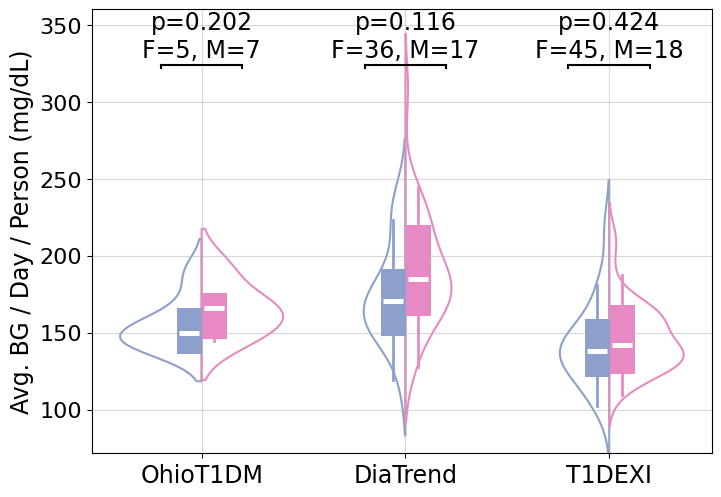

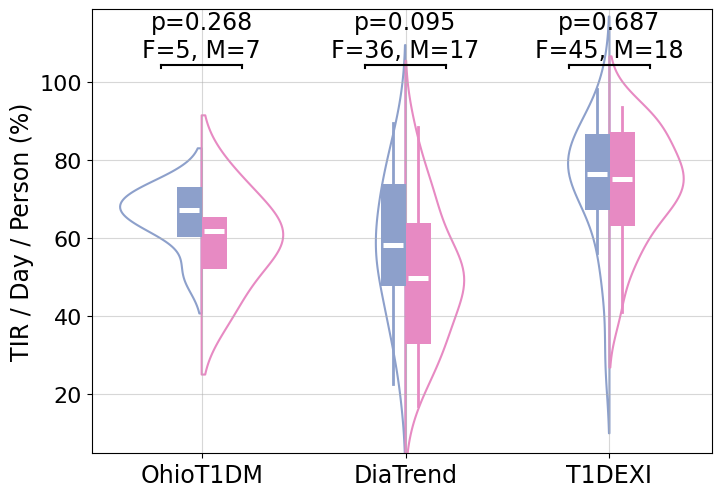

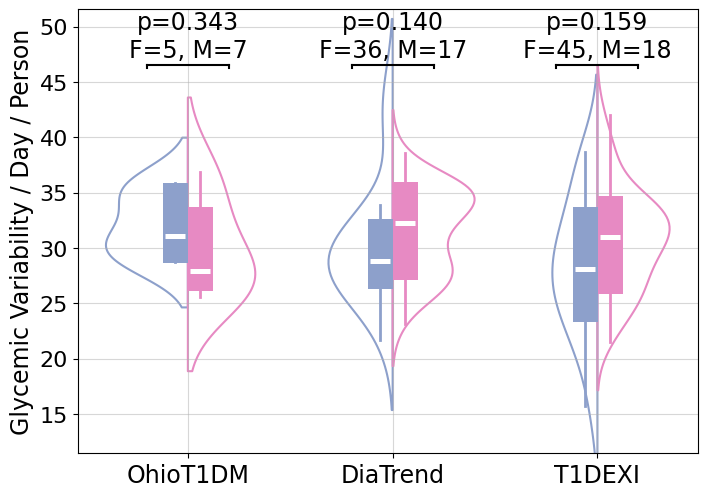

In [3]:
excel_file_path = "./Result Table (1).xlsx"
demographics = pd.read_excel(excel_file_path, sheet_name="demographics")

demographics.rename(columns={
    'AVE CGM (daily avg)': 'Avg. BG / Day / Person (mg/dL)',
    'TIR ratio': 'TIR / Day / Person (%)',
    'Gly var (daily std)': 'Glycemic Variability / Day / Person'
}, inplace=True)
demographics['TIR / Day / Person (%)'] = demographics['TIR / Day / Person (%)'] * 100
# Separate the DataFrame into three sub-DataFrames by dataset type
ohio = demographics[demographics['Dataset'] == 'OhioT1DM']
diatrend = demographics[demographics['Dataset'] == 'DiaTrend']
t1dexi = demographics[demographics['Dataset'] == 'T1DEXI']

# Combine the three DataFrames into one for plotting
combined_df = pd.concat([
    ohio.assign(Dataset='OhioT1DM'),
    diatrend.assign(Dataset='DiaTrend'),
    t1dexi.assign(Dataset='T1DEXI')
])

# Perform Mann-Whitney U test between the two gender groups for each specified column and dataset
def perform_mann_whitney_u_test(data, column_name):
    female_data = data[data['Gender'] == 'F'][column_name]
    male_data = data[data['Gender'] == 'M'][column_name]
    
    if len(female_data) > 0 and len(male_data) > 0:
        u_stat, p_value = mannwhitneyu(female_data, male_data, alternative='two-sided')
        return u_stat, p_value
    else:
        return None, None

# Create a half-half violin plot for each specified column by gender and dataset
def create_grouped_violin_plot(column_name):
    plt.figure(figsize=(8, 6))
    set2color = sns.color_palette("Set2")
    # Create the split violin plot
    ax = sns.violinplot(
        x='Dataset', 
        y=column_name, 
        hue='Gender', 
        data=combined_df, 
        split=True, 
        palette={'F': set2color[3], 'M': set2color[2]}, 
        linewidth=1.5,
        fill=False,
        inner_kws=dict(box_width=18, whis_width=2)

    )
    ax.legend_.remove()  # Remove the legend
    # Add labels
    plt.xlabel("")
    plt.ylabel(column_name, fontsize=17)
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=16)
    # plt.legend(title='Gender', fontsize=14)
    plt.grid(alpha=0.5)
    
    # Get the y-axis limits for consistent annotation placement
    y_max = combined_df[column_name].max()
    y_min = combined_df[column_name].min()
    offset = (y_max - y_min) * 0.05
    
    # Adjust y-limits to create enough space for the annotations
    plt.ylim(y_min - offset*3, y_max + offset * 5)
    
    # Increase top margin to avoid cutoff issues
    plt.subplots_adjust(top=0.85)
    
    for i, dataset in enumerate(combined_df['Dataset'].unique()):
        data = combined_df[combined_df['Dataset'] == dataset]
        u_stat, p_value = perform_mann_whitney_u_test(data, column_name)
        
        # Get counts for M and F
        count_f = data[data['Gender'] == 'F'].shape[0]
        count_m = data[data['Gender'] == 'M'].shape[0]
        
        if p_value is not None:
            # Draw a horizontal bracket
            bracket_height = y_max + offset * 1.5
            bracket_bottom = bracket_height - offset * 0.2
            
            # Horizontal line
            plt.plot([i - 0.2, i + 0.2], [bracket_height, bracket_height], color='black', lw=1.5)
            # Left vertical line
            plt.plot([i - 0.2, i - 0.2], [bracket_bottom, bracket_height], color='black', lw=1.5)
            # Right vertical line
            plt.plot([i + 0.2, i + 0.2], [bracket_bottom, bracket_height], color='black', lw=1.5)

            # Annotate p-value and counts above the bracket
            text = f'p={p_value:.3f}\nF={count_f}, M={count_m}'
            plt.text(i, bracket_height + offset * 0.5, text, ha='center', fontsize=17, color='black')

    # Show the plot
    plt.show()

# Create grouped violin plots and perform Mann-Whitney U tests for the specified columns
columns = ['Avg. BG / Day / Person (mg/dL)', 'TIR / Day / Person (%)', 'Glycemic Variability / Day / Person']
for column in columns:
    create_grouped_violin_plot(column)


In [7]:
excel_file_path = "./Result Table (1).xlsx"
result_df = pd.read_excel(excel_file_path, sheet_name="cross_dataset")
retrained_result = result_df[["Dataset", "SubjectID", "Martinsson_retrained", "vanDoorn_retrained", "Deng_retrained", "Lee_retrained", "Rabby_retrained", "Li_retrained"]].copy()

# Merge the two datasets on "Dataset" and "SubjectID"/"Patient_id"
merged_df = pd.merge(
    retrained_result,
    demographics,
    left_on=["Dataset", "SubjectID"],
    right_on=["Dataset", "Patient_id"],
    how="inner"  # Use "inner" to keep only matching rows
)

# Drop the redundant "Patient_id" column after merging
merged_df = merged_df.drop(columns=["Patient_id"])

# List of methods to plot
methods = ['Martinsson_retrained', 
           'Li_retrained',
           'vanDoorn_retrained', 
           'Deng_retrained', 
           'Rabby_retrained',
            'Lee_retrained',
           ]

# Mapping of methods to their display names
method_labels = {
    'Martinsson_retrained': 'Martinsson, 2019',
    'Li_retrained': 'Li, 2020',
    'vanDoorn_retrained': 'van Doorn, 2021',
    'Deng_retrained': 'Deng, 2021',
    'Rabby_retrained': 'Rabby, 2021',
    'Lee_retrained': 'Lee, 2023',
    
}

# Melt the dataframe to have a long-form dataframe suitable for seaborn
melted_df = merged_df.melt(id_vars=['SubjectID', 'Gender'], 
                           value_vars=methods, 
                           var_name='Method', value_name='RMSE')

RMSE Difference between two gender groups on Martinsson, 2019
Male RMSE avg: 19.856863789263816, sd = 3.943203310079014
Female RMSE avg: 21.84223478566376, sd = 4.334205677770484
RMSE Difference between two gender groups on Li, 2020
Male RMSE avg: 21.362172547619046, sd = 4.710443653536045
Female RMSE avg: 23.732960651162788, sd = 5.960172856273922
RMSE Difference between two gender groups on van Doorn, 2021
Male RMSE avg: 20.10003758074762, sd = 3.9127102851461575
Female RMSE avg: 22.025639884861846, sd = 4.312474058253829
RMSE Difference between two gender groups on Deng, 2021
Male RMSE avg: 20.259999999999998, sd = 3.887914730595432
Female RMSE avg: 22.243488372093022, sd = 4.32066849033262
RMSE Difference between two gender groups on Rabby, 2021
Male RMSE avg: 21.543089535714284, sd = 4.537073552473217
Female RMSE avg: 24.11937223255814, sd = 4.601380568007746
RMSE Difference between two gender groups on Lee, 2023
Male RMSE avg: 20.79357142857143, sd = 4.139350547994658
Female RMSE

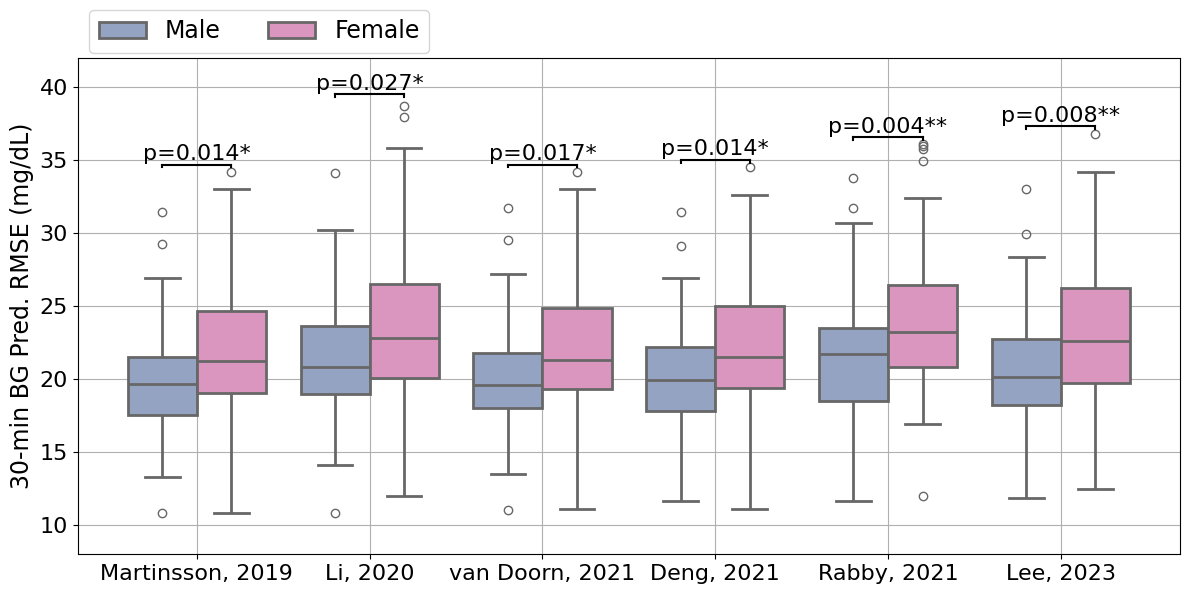

In [ ]:
# Replace method names with their display names
melted_df['Method'] = melted_df['Method'].map(method_labels)

# Create the box plot
set2_colors = sns.color_palette("Set2")
plt.figure(figsize=(12, 6))
sns.boxplot(x='Method', y='RMSE', hue='Gender', data=melted_df, 
            palette={'F': set2_colors[3], 'M': set2_colors[2]}, linewidth=2)

# Set y-axis limit
plt.ylim(8, 42)

# Perform t-tests and annotate p-values
for i, method in enumerate(method_labels.values()):
    male_rmse = melted_df[(melted_df['Method'] == method) & (melted_df['Gender'] == 'M')]['RMSE']
    female_rmse = melted_df[(melted_df['Method'] == method) & (melted_df['Gender'] == 'F')]['RMSE']
    print(f"RMSE Difference between two gender groups on {method}")
    print(f"Male RMSE avg: {np.average(male_rmse.values)}, sd = {np.std(male_rmse.values)}")
    print(f"Female RMSE avg: {np.average(female_rmse.values)}, sd = {np.std(female_rmse.values)}")
    # print(f"RMSE Difference between two gender groups on method{method}: {np.average(female_rmse.values)-np.average(male_rmse.values)} ")
    t_stat, p_value = ttest_ind(male_rmse, female_rmse)
    # print(f"On {method}: t_stat:{t_stat}, p_value:{p_value}.")
    
    # Get the maximum y value for the current method
    max_y = min(max(male_rmse.max(), female_rmse.max()), 39)  # Cap at 38 to fit within ylim
    
    # Add a rectangle bracket with adjusted position
    plt.plot([i - 0.2, i + 0.2], [max_y + 0.5, max_y + 0.5], color='black')
    plt.plot([i - 0.2, i - 0.2], [max_y + 0.3, max_y + 0.5], color='black')
    plt.plot([i + 0.2, i + 0.2], [max_y + 0.3, max_y + 0.5], color='black')

    # Determine significance stars and format p-value text
    if p_value < 0.001:
        p_text = 'p < 0.001***'
    elif p_value < 0.01:
        p_text = f'p={p_value:.3f}**'
    elif p_value < 0.05:
        p_text = f'p={p_value:.3f}*'
    else:
        p_text = f'p={p_value:.3f}'
    
    # Add p-value annotation with adjusted position
    plt.text(i, max_y + 0.8, p_text, 
             horizontalalignment='center',    
             fontsize=16,
             color='black')

# Update legend labels
# Update legend labels and position
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['Male', 'Female'], 
          fontsize=17,
          bbox_to_anchor=(0, 1.12), ncol = 2, # Position legend outside
          loc='upper left')  # Align to upper left
plt.xlabel('', fontsize=17)
plt.ylabel('30-min BG Pred. RMSE (mg/dL)', fontsize=17)
plt.grid(True)

# Rotate x-axis labels
plt.xticks( fontsize=16)
plt.yticks(fontsize=16)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()